In [32]:
import numpy as np
import matplotlib.pyplot as plt
import os

from joblib import Parallel, delayed, parallel_backend
# from psiam_tied_dv_map_utils_for_noise import psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_V_A_change_added_noise_fn, up_RTs_fit_OPTIM_V_A_change_added_noise_fn, down_RTs_fit_OPTIM_V_A_change_added_noise_fn, PA_with_LEDON_2
from psiam_tied_dv_map_utils_with_PDFs import up_RTs_fit_OPTIM_V_A_change_gamma_omega_fn, down_RTs_fit_OPTIM_V_A_change_gamma_omega_fn
import pandas as pd
import random
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from scipy.integrate import trapezoid as trapz
from pyvbmc import VBMC
import corner
from diagnostics_class import Diagnostics
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_fn, CDF_RT_fn
from scipy.integrate import cumulative_trapezoid as cumtrapz
import pickle
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_fn
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_m3_probfn

# get og data

In [33]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]


# t_stim, t_LED, ABL, ILD
t_stim_and_led_tuple = [(row['intended_fix'], row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
ABL_arr = df['ABL'].unique(); ABL_arr.sort()
ILD_arr = df['ILD'].unique(); ILD_arr.sort()


# 1 is right , -1 is left
df['choice'] = df['response_poke'].apply(lambda x: 1 if x == 3 else (-1 if x == 2 else random.choice([1, -1])))
# 1 or 0 if the choice was correct or not
df['correct'] = (df['ILD'] * df['choice']).apply(lambda x: 1 if x > 0 else 0)


# data for vbmc

In [34]:
# LED OFF
df_led_off = df[df['LED_trial'] == 0]
print(f'len of LED off: {len(df_led_off)}')

# remove ILD 16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]
# TEMP: remove ILD 8 also
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([8, -8]) ]
print(f'len of ILD 16, 8 removed: {len(df_led_off)}')

# valid trials
df_led_off_valid_trials = df_led_off[df_led_off['success'].isin([1,-1])]
print(f'len of led off valid trials = {len(df_led_off_valid_trials)}')

# remove trials with RT > 1s
df_led_off_valid_trials = df_led_off_valid_trials[df_led_off_valid_trials['timed_fix'] - df_led_off_valid_trials['intended_fix'] < 1]
print(f'len of valid trials < 1s : {len(df_led_off_valid_trials)}')

len of LED off: 66226
len of ILD 16, 8 removed: 39722
len of led off valid trials = 31945
len of valid trials < 1s : 31308


# condition filtered for vbmc

In [35]:
conditions = {'ABL': [40], 'ILD': [2]}


In [36]:
# Applying the filter
df_led_off_valid_trials_cond_filtered = df_led_off_valid_trials[
    (df_led_off_valid_trials['ABL'].isin(conditions['ABL'])) & 
    (df_led_off_valid_trials['ILD'].isin(conditions['ILD']))
]

In [37]:
print(f'lenm of conditioned trials = {len(df_led_off_valid_trials_cond_filtered)}')
ABLs_cond = df_led_off_valid_trials_cond_filtered['ABL'].unique()
ILDs_cond = df_led_off_valid_trials_cond_filtered['ILD'].unique()
print(ABLs_cond)
print(ILDs_cond)

lenm of conditioned trials = 1716
[40]
[2.]


# vbmc params

In [38]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
del_go = 0.13 

# other params
# Z_E = 0
K_max = 10

# LED Off - no noise
noise = 0


# loglike fn

In [39]:
def compute_loglike_trial(row, gamma, omega, t_E_aff, w):
    # data
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_LED = row['intended_fix'] - row['LED_onset_time']

    response_poke = row['response_poke']
    

    t_pts = np.arange(t_stim, t_stim + 1, 0.001)
    P_A_LED_change = np.array([PA_with_LEDON_2(i, V_A, V_A_post_LED, theta_A, 0, t_LED, t_A_aff) for i in t_pts])
    area_btn_stim_and_1s = trapz(P_A_LED_change, t_pts)
    trunc_factor_p_joint = area_btn_stim_and_1s
    
    bound_val = 2*response_poke - 5
    P_joint_rt_choice = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_w_fn(rt, t_LED, V_A, V_A_post_LED, theta_A,\
                                                                        gamma, omega, t_stim, t_A_aff, t_E_aff, del_go, w, bound_val, K_max)
      
    
    P_joint_rt_choice_trunc = max(P_joint_rt_choice / (trunc_factor_p_joint + 1e-10), 1e-10)
    
    wt_log_like = np.log(P_joint_rt_choice_trunc)


    return wt_log_like


def vbmc_loglike_fn(params):
    gamma, omega, t_E_aff, w = params

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike_trial)(row, gamma, omega, t_E_aff, w) \
                                     for _, row in df_led_off_valid_trials_cond_filtered.iterrows())
    
    return np.sum(all_loglike)

# bounds

In [40]:
gamma_bounds = [0.02, 2]
gamma_plausible_bounds = [0.09, 0.9]

omega_bounds = [0.05, 50]
omega_plausible_bounds = [0.5, 10]

t_E_aff_bounds = [0, 1]
t_E_aff_plausible_bounds = [0.01, 0.2]

w_bounds = [0.01, 0.99]
w_plausible_bounds = [0.3, 0.7]


# prior

In [41]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_fn(params):
    gamma, omega, t_E_aff, w = params
    gamma_logpdf = trapezoidal_logpdf(gamma, gamma_bounds[0], gamma_plausible_bounds[0], gamma_plausible_bounds[1], gamma_bounds[1])
    omega_logpdf = trapezoidal_logpdf(omega, omega_bounds[0], omega_plausible_bounds[0], omega_plausible_bounds[1], omega_bounds[1])
    t_E_aff_logpdf = trapezoidal_logpdf(t_E_aff, t_E_aff_bounds[0], t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1], t_E_aff_bounds[1])
    w_logpdf = trapezoidal_logpdf(w, w_bounds[0], w_plausible_bounds[0], w_plausible_bounds[1], w_bounds[1])

    return gamma_logpdf + omega_logpdf + t_E_aff_logpdf + w_logpdf

# prior + loglike

In [42]:
def vbmc_joint_fn(params):
    priors = vbmc_prior_fn(params)
    loglike = vbmc_loglike_fn(params)

    return priors + loglike

# vbmc

In [ ]:
# Add bounds for 'w'
lb = np.array([gamma_bounds[0], omega_bounds[0], t_E_aff_bounds[0], w_bounds[0]])
ub = np.array([gamma_bounds[1], omega_bounds[1], t_E_aff_bounds[1], w_bounds[1]])

plb = np.array([gamma_plausible_bounds[0], omega_plausible_bounds[0], t_E_aff_plausible_bounds[0], w_plausible_bounds[0]])
pub = np.array([gamma_plausible_bounds[1], omega_plausible_bounds[1], t_E_aff_plausible_bounds[1], w_plausible_bounds[1]])

# Initialize with random values within plausible bounds
np.random.seed(42)
gamma_0 = np.random.uniform(gamma_plausible_bounds[0], gamma_plausible_bounds[1])
omega_0 = np.random.uniform(omega_plausible_bounds[0], omega_plausible_bounds[1])
t_E_aff_0 = np.random.uniform(t_E_aff_plausible_bounds[0], t_E_aff_plausible_bounds[1])
w_0 = np.random.uniform(w_plausible_bounds[0], w_plausible_bounds[1])

x_0 = np.array([gamma_0, omega_0, t_E_aff_0, w_0])

# Run VBMC
vbmc = VBMC(vbmc_joint_fn, x_0, lb, ub, plb, pub, options={'display': 'on'})
vp, results = vbmc.optimize()


In [ ]:
vbmc.save(f'test_with_w_fit.pkl')

In [44]:
with open(f"test_with_w_fit.pkl", 'rb') as f:
    vp = pickle.load(f)

vp = vp.vp

# vbmc sample

In [45]:
vp_samples = vp.sample(int(1e5))[0]

gamma_samples = vp_samples[:, 0]
omega_samples = vp_samples[:, 1]
t_E_aff_samples = vp_samples[:, 2]
w_samples = vp_samples[:, 3]

In [46]:
gamma = gamma_samples.mean()
omega = omega_samples.mean()
t_E_aff = t_E_aff_samples.mean()
w = w_samples.mean()

# corner

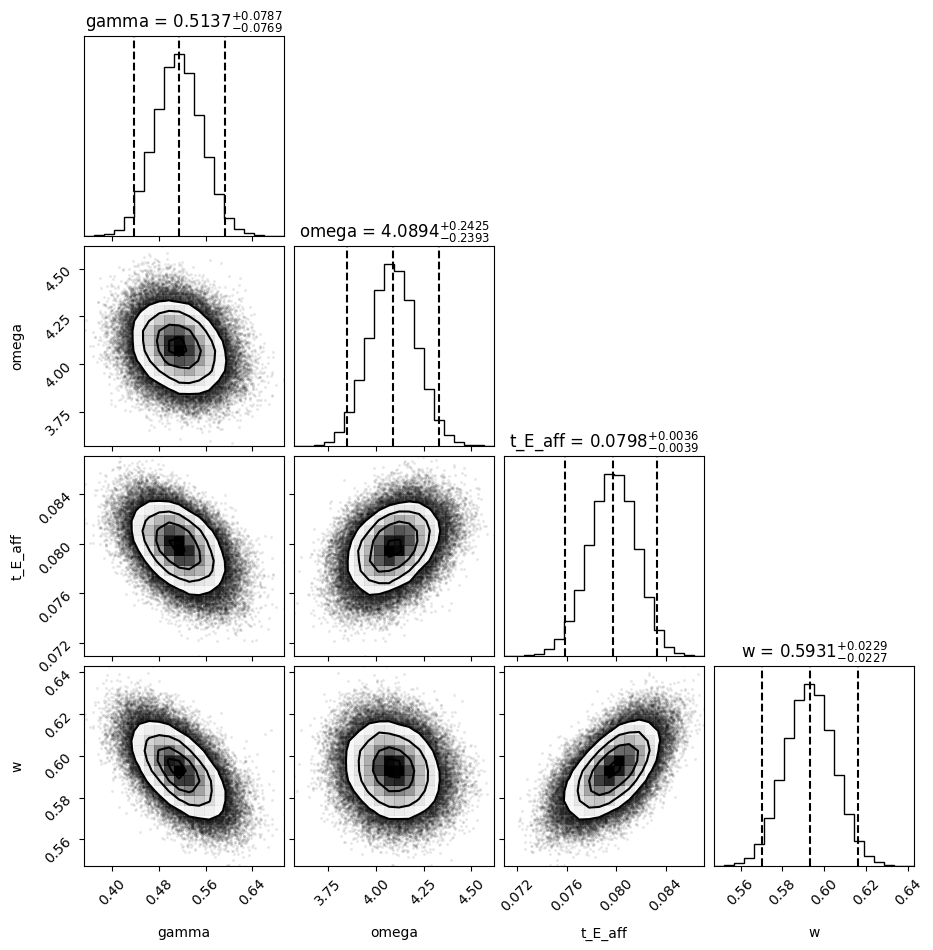

In [47]:
# plot the corner plot
corner_samples = np.vstack([gamma_samples, omega_samples, t_E_aff_samples, w_samples]).T
percentiles = np.percentile(corner_samples, [0, 100], axis=0)
_ranges = [(percentiles[0, i], percentiles[1, i]) for i in np.arange(corner_samples.shape[1])]
param_labels = [ 'gamma', 'omega', 't_E_aff', 'w']

corner.corner(
    corner_samples,
    labels=param_labels,
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f"
);


# Diagnostics

## exp data df prepare

In [48]:
# DATA
df_led_off = df[df['LED_trial'] == 0]

# < 1s RTs
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]
# remove truncated aborts
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]
# renaming
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)

### ABORTS + VALID TRIALS + ABL, ILD CONDITION
data_df_led_off_with_aborts_cond_filtered = data_df_led_off_with_aborts[
    (data_df_led_off_with_aborts['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_with_aborts['ILD'].isin(conditions['ILD']))
]

data_df_led_off_valid = data_df_led_off_with_aborts[ data_df_led_off_with_aborts['success'].isin([1,-1]) ]

# VALID TRIALS CONDITION
df_led_off_valid_trials_cond_filtered = data_df_led_off_valid[
    (data_df_led_off_valid['ABL'].isin(conditions['ABL'])) & 
    (data_df_led_off_valid['ILD'].isin(conditions['ILD']))
]

df_led_off_valid_trials_cond_filtered['ABL'].unique(), df_led_off_valid_trials_cond_filtered['ILD'].unique()

(array([40]), array([2.]))

## up and down RT

In [49]:
from single_cond_utils import PA_with_LEDON_2_VEC
# PA_with_LEDON_2(t, v, vON, a, tfix, tled, delta_A)

N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = PA_with_LEDON_2_VEC(t_pts, V_A, V_A_post_LED, theta_A, t_stim, t_LED, t_A_aff)
    P_A_samples[idx, :] = pdf

P_A_samples_mean = np.mean(P_A_samples, axis=0)
C_A_mean = cumtrapz(P_A_samples_mean, t_pts, initial=0)

In [50]:
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn

In [51]:
up_wrt_stim = np.zeros_like(t_pts)
down_wrt_stim = np.zeros_like(t_pts)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    
    up_wrt_stim[idx] =  up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, 1, K_max)
    down_wrt_stim[idx] = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, -1, K_max)


In [52]:
bins = np.arange(-1,1,0.02)
bin_centers = (bins[:-1] + bins[1:]) / 2



## data
data_up = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == 1]
data_down = df_led_off_valid_trials_cond_filtered[df_led_off_valid_trials_cond_filtered['choice'] == -1]

data_up_rt = data_up['rt'] - data_up['t_stim']
data_up_rt_hist, _ = np.histogram(data_up_rt, bins=bins, density=True)

data_down_rt = data_down['rt'] - data_down['t_stim']
data_down_rt_hist, _ = np.histogram(data_down_rt, bins=bins, density=True)

frac_up_data = len(data_up) / len(df_led_off_valid_trials_cond_filtered)
frac_down_data = len(data_down) / len(df_led_off_valid_trials_cond_filtered)

areas theory up = 0.785, down = 0.212
frac up data = 0.786, down data = 0.214


Text(0, 0.5, 'density')

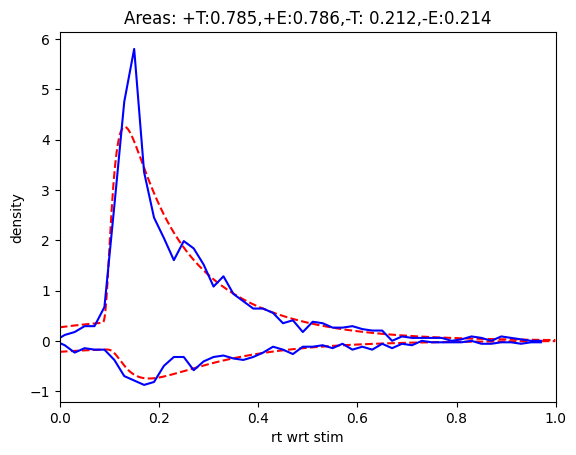

In [53]:
# RTDs - up and down
plt.plot(t_pts, up_wrt_stim, ls='--', color='r')
plt.plot(t_pts, -down_wrt_stim, ls='--', color='r')

plt.plot(bin_centers, data_up_rt_hist*frac_up_data, color='b')
plt.plot(bin_centers, -data_down_rt_hist*frac_down_data, color='b')

theory_area_up = trapz(up_wrt_stim, t_pts)
theory_area_down = trapz(down_wrt_stim, t_pts)

print(f'areas theory up = {theory_area_up :.3f}, down = {theory_area_down :.3f}')
print(f'frac up data = {frac_up_data :.3f}, down data = {frac_down_data :.3f}')
plt.xlim(0,1)
plt.title(f'Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},-T:{theory_area_down: .3f},-E:{frac_down_data :.3f}')

plt.xlabel('rt wrt stim')
plt.ylabel('density')

## accuracy

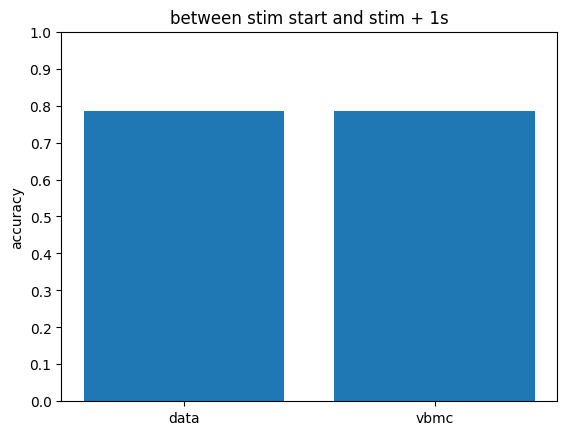

In [54]:
## 2. Accuracy
xlabels = ['data', 'vbmc']
if conditions['ILD'][0] > 0:
    accuracy_data_and_theory = [frac_up_data, theory_area_up]
else:
    accuracy_data_and_theory = [frac_down_data, theory_area_down]

plt.bar(xlabels, accuracy_data_and_theory)
plt.ylabel('accuracy')
plt.title('between stim start and stim + 1s')
plt.ylim(0,1)
plt.yticks(np.arange(0, 1.1, 0.1));

# tachometric

In [55]:
from psiam_tied_dv_map_utils_with_PDFs import all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn

In [56]:
# P_rt = np.zeros_like(t_pts)
tacho = np.zeros_like(t_pts)
# all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)
for idx, t in enumerate(t_pts):
    P_A = P_A_samples_mean[idx]
    C_A = C_A_mean[idx]
    
    P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, 1, K_max)
    P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, del_go, w, -1, K_max)
    
    if conditions['ILD'][0] > 0:
        P_rt_c = P_up
    else:
        P_rt_c = P_down
        
    P_rt = P_up + P_down
    # P_rt = all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn(t, P_A, C_A, gamma, omega, t_E_aff, w, K_max)

    tacho[idx] = P_rt_c / P_rt

In [57]:
df_led_off_valid_trials_cond_filtered_copy = df_led_off_valid_trials_cond_filtered.copy()
df_led_off_valid_trials_cond_filtered_copy.loc[:, 'RT_bin'] = pd.cut(df_led_off_valid_trials_cond_filtered_copy['rt'] - df_led_off_valid_trials_cond_filtered_copy['t_stim'],\
                                                              bins = bins, include_lowest=True)
grouped_by_rt_bin = df_led_off_valid_trials_cond_filtered_copy.groupby('RT_bin', observed=False)['correct'].agg(['mean', 'count'])
grouped_by_rt_bin['bin_mid'] = grouped_by_rt_bin.index.map(lambda x: x.mid)

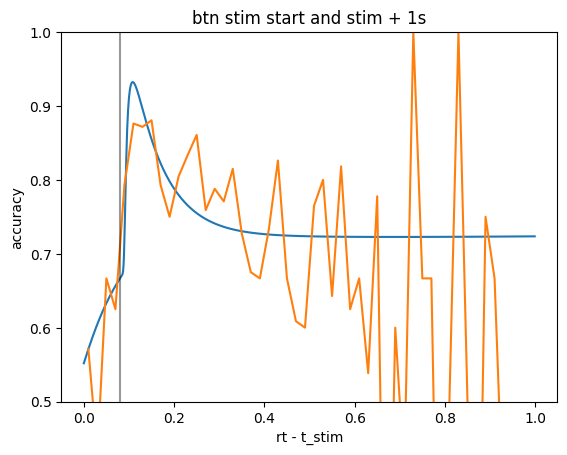

In [58]:
##  3. Tacho
plt.plot(t_pts, tacho)
plt.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')

plt.ylim(0.5,1)
plt.xlabel('rt - t_stim')
plt.ylabel('accuracy')
plt.title('btn stim start and stim + 1s')
plt.axvline(t_E_aff, alpha=0.4, color='k')

# testing with w

In [59]:
# The more the bias, more the fall  and if initial point is close to the wrong side, tacho wil rise
# basically the accuracy gain/loss due to initial advantage is dimnished after some time => tacho fall or rise


## gpt 
# So, does the tachometric curve fall when starting point is biased?
# Not exactly fall, but it peaks early and then may decline or plateau — here’s why:

# With initial bias toward the correct bound, fast responses are artificially boosted in accuracy due to bias.

# As RT increases, the influence of the starting bias diminishes, and the decision becomes more evidence-driven.

# If the evidence is noisy or the drift rate is low,
#  accuracy can slightly decline before plateauing — leading to a falling tail in the tachometric curve.

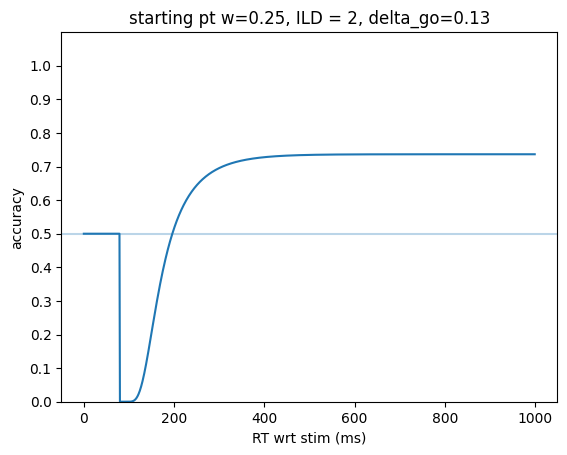

Text(0.5, 1.0, 'w=0.25')

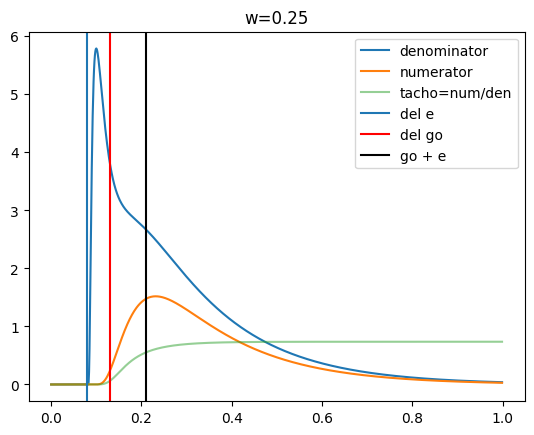

In [112]:

# P_rt = np.zeros_like(t_pts)
w_test = 0.25
m3_up_prob = 0.5
tacho_test = np.zeros_like(t_pts)
del_go_test = del_go + (0)
# all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)
P_rt_vs_t = np.zeros_like(t_pts)
P_up_vs_t = np.zeros_like(t_pts)

for idx, t in enumerate(t_pts):
    # P_A = P_A_samples_mean[idx]
    # C_A = C_A_mean[idx]
    # TEMP
    P_A = 0
    C_A = 0

    
    P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_m3_probfn(t, P_A, C_A, gamma, omega, t_E_aff, del_go_test, w_test, 1, m3_up_prob, K_max)
    P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_m3_probfn(t, P_A, C_A, gamma, omega, t_E_aff, del_go_test, w_test, -1, m3_up_prob, K_max)
    
    if conditions['ILD'][0] > 0:
        P_rt_c = P_up
    else:
        P_rt_c = P_down
        
    P_rt = P_up + P_down

    # P_rt = all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn(t, P_A, C_A, gamma, omega, t_E_aff, w, K_max)
    P_rt_vs_t[idx] = P_rt
    P_up_vs_t[idx] = P_up
    if P_rt == 0:
        tacho_test[idx] = 0.5
    else:
        tacho_test[idx] = (P_rt_c) / (P_rt + 1e-10)


plt.plot(t_pts*1000, tacho_test)
# plt.title(f'w = {w_test}, random choice up prob ={m3_up_prob}')
plt.title(f'starting pt w={w_test}, ILD = {conditions['ILD'][0]}, delta_go={del_go_test}')
plt.xlabel('RT wrt stim (ms)')
plt.ylabel('accuracy')
plt.ylim(0, 1.1)
plt.yticks(np.arange(0, 1.1, 0.1));
plt.axhline(0.5, alpha=0.3)
plt.show()

plt.plot(t_pts, P_rt_vs_t, label='denominator')
plt.plot(t_pts, P_up_vs_t, label='numerator')
plt.plot(t_pts, (P_up_vs_t) / (P_rt_vs_t + 1e-10), alpha = 0.5, label='tacho=num/den')
plt.axvline(t_E_aff, label='del e')
plt.axvline(del_go_test, color='r', label='del go')
plt.axvline(t_E_aff + del_go_test, color='k', label='go + e')

plt.legend()
plt.title(f'w={w_test}')

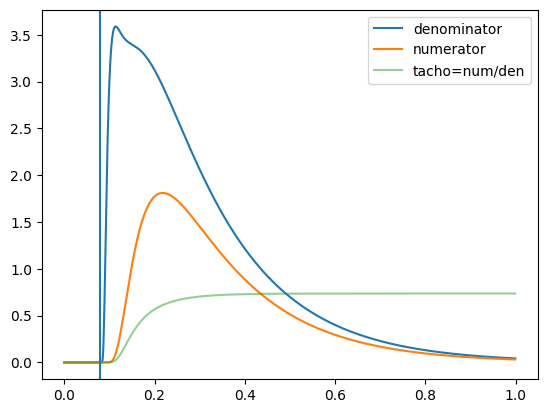

In [ ]:
# up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_NOT_m3_probfn
# P_rt = np.zeros_like(t_pts)
w_test_arr = [0.3, 0.4, 0.6, 0.7]
for w_test in w_test_arr:
    m3_up_prob = 0.5
    tacho_test = np.zeros_like(t_pts)
    del_go_test = del_go + (0)
    # all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_fn(t, P_A, C_A, gamma, omega, t_E_aff, K_max)
    for idx, t in enumerate(t_pts):
        P_A = P_A_samples_mean[idx]
        C_A = C_A_mean[idx]
        
        P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_m3_probfn(t, P_A, C_A, gamma, omega, t_E_aff, del_go_test, w_test, 1, m3_up_prob, K_max)
        P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_m3_probfn(t, P_A, C_A, gamma, omega, t_E_aff, del_go_test, w_test, -1, m3_up_prob, K_max)
        
        if conditions['ILD'][0] > 0:
            P_rt_c = P_up
        else:
            P_rt_c = P_down
            
        P_rt = P_up + P_down
        # P_rt = all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn(t, P_A, C_A, gamma, omega, t_E_aff, w, K_max)

        tacho_test[idx] = P_rt_c / P_rt


    plt.plot(t_pts*1000, tacho_test, label=f'w={w_test}')
    # plt.title(f'w = {w_test}, random choice up prob ={m3_up_prob}')
plt.title(f'starting pt w={w_test}, ILD = {conditions['ILD'][0]}, delta_go={del_go_test}')
plt.xlabel('RT wrt stim (ms)')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1));
plt.axhline(0.5, alpha=0.3)
plt.legend()

# make PA win 

In [ ]:
from psiam_tied_no_dv_map_utils import rho_A_t_fn

In [ ]:
N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(-5, 5, 0.001)

V_A_test = V_A
theta_A_test = theta_A
t_A_aff_test = 0 

old_proactive = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = [rho_A_t_fn(t + t_stim - t_A_aff_test, V_A_test, theta_A_test) for t in t_pts]
    old_proactive[idx, :] = pdf

P_A_samples_mean_test_2 = np.mean(old_proactive, axis = 0)
C_A_mean_test = cumtrapz(P_A_samples_mean_test_2, t_pts, initial=0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_pts, C_A_mean_test)

plt.subplot(1,2,2)
plt.plot(t_pts, P_A_samples_mean_test_2)

## match PA LED ON VEC fn

In [ ]:
N_theory = int(5e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts_test = np.arange(-5, 5, 0.001)

V_A_test = V_A
theta_A_test = theta_A
t_A_aff_test = 0

print(f'V_A test = {V_A_test}, theta_A = {theta_A_test}, t_A_aff={t_A_aff}')
P_A_samples = np.zeros((N_theory, len(t_pts_test)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    # pdf = PA_with_LEDON_2_VEC(t_pts_test, V_A_test, V_A_test, theta_A_test, t_stim, t_LED, t_A_aff_test)
    pdf = PA_with_LEDON_2_VEC(t_pts_test, V_A_test, V_A_test, theta_A_test, t_stim, t_LED, t_A_aff_test)
    
    P_A_samples[idx, :] = pdf

P_A_samples_mean_test = np.mean(P_A_samples, axis=0)
C_A_mean_test = cumtrapz(P_A_samples_mean_test, t_pts_test, initial=0)
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(t_pts_test, C_A_mean_test)
plt.ylim(0,1)
plt.title('cdf')

plt.subplot(1,2,2)
plt.plot(t_pts_test, P_A_samples_mean_test, label='PA LED vec')
plt.plot(t_pts_test, P_A_samples_mean_test_2, color='k', ls='--', label='classic PA pdf')
plt.title('pdf')
plt.legend()

In [ ]:
trapz(P_A_samples_mean_test, t_pts_test)

# does tacho change with increase in del go in non-M3 readout rule

In [ ]:
N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

V_A_test = V_A + 0.9
theta_A_test = theta_A
t_A_aff_test = t_A_aff 
print(f'V_A test = {V_A_test}, theta_A = {theta_A_test}')
P_A_samples = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = PA_with_LEDON_2_VEC(t_pts, V_A_test, V_A_test, theta_A_test, t_stim, t_LED, t_A_aff_test)
    P_A_samples[idx, :] = pdf

P_A_samples_mean_test = np.mean(P_A_samples, axis=0)
C_A_mean_test = cumtrapz(P_A_samples_mean_test, t_pts, initial=0)
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(t_pts, C_A_mean_test)
plt.ylim(0,1)

plt.subplot(1,2,2)
plt.plot(t_pts, P_A_samples_mean_test)

In [ ]:
gamma

In [ ]:
N_theory = int(1e3)
random_indices = np.random.randint(0, len(t_stim_and_led_tuple), N_theory)
t_pts = np.arange(0, 1, 0.001)

V_A_test = V_A
theta_A_test = theta_A
t_A_aff_test = 0

old_proactive = np.zeros((N_theory, len(t_pts)))
for idx in range(N_theory):
    t_stim, t_LED = t_stim_and_led_tuple[random_indices[idx]]
    pdf = [rho_A_t_fn(t + t_stim - t_A_aff_test, V_A_test, theta_A_test) for t in t_pts]
    old_proactive[idx, :] = pdf

P_A_samples_mean_test = np.mean(old_proactive, axis = 0)
C_A_mean_test = cumtrapz(P_A_samples_mean_test, t_pts, initial=0)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(t_pts, C_A_mean_test)

plt.subplot(1,2,2)
plt.plot(t_pts, P_A_samples_mean_test)

In [ ]:
# generate artifical PA_test
from scipy.stats import beta
pdf_vals = beta.pdf(t_pts, a=2, b=30) 
# plt.plot(t_pts, pdf_vals)
plt.show()
plt.plot(t_pts, cumtrapz(pdf_vals, t_pts, initial=0))
plt.xticks(np.arange(0, 1.1, 0.1));

In [ ]:
P_A_samples_mean_test = pdf_vals
# P_A_samples_mean_test = np.ones_like(t_pts) * 0.001
C_A_mean_test = cumtrapz(P_A_samples_mean_test, t_pts, initial=0)

In [ ]:
from psiam_tied_dv_map_utils_with_PDFs import up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_NOT_m3_probfn
plt.figure(figsize=(20,8))
# P_rt = np.zeros_like(t_pts)
w_test = 0.3
m3_up_prob = np.nan
tacho_test = np.zeros_like(t_pts)
t_E_aff_test = t_E_aff
for go_inc in [-t_E_aff_test, t_E_aff_test, 0.2]:
    del_go_test = t_E_aff_test + go_inc

    for idx, t in enumerate(t_pts):
        P_A = P_A_samples_mean_test[idx]
        C_A = C_A_mean_test[idx]
        gamma_test = gamma  * 8
        P_up = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_NOT_m3_probfn(t, P_A, C_A, gamma_test, omega, t_E_aff_test, del_go_test, w_test, 1, m3_up_prob, K_max)
        P_down = up_or_down_RTs_fit_OPTIM_V_A_change_gamma_omega_P_A_C_A_w_wrt_stim_NOT_m3_probfn(t, P_A, C_A, gamma_test, omega, t_E_aff_test, del_go_test, w_test, -1, m3_up_prob, K_max)
        
        if conditions['ILD'][0] > 0:
            P_rt_c = P_up
        else:
            P_rt_c = P_down
            
        P_rt = P_up + P_down
        # P_rt = all_RTs_fit_OPTIM_omega_gamma_PA_CA_wrt_stim_w_fn(t, P_A, C_A, gamma, omega, t_E_aff, w, K_max)
        if P_rt == 0:
            tacho_test[idx] = 0.5
        else:
            tacho_test[idx] = P_rt_c / P_rt


    plt.plot(t_pts, tacho_test, label=f'delgo ={del_go_test :.2f}')
# plt.title(f'w = {w_test}, random choice up prob ={m3_up_prob}')
plt.title(f'starting pt w={w_test}, ILD = {conditions['ILD'][0]}, t_E_aff={t_E_aff_test :.3f}')
plt.xlabel('RT wrt stim (s)')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, 0.1));
plt.axhline(0.5, alpha=0.3, color='k', ls='--')
plt.axvline(t_E_aff_test, label='sens delay', color='k', alpha=0.5, ls='--')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.legend()
# plt.ylim(0.45, 0.6)

In [ ]:
from psiam_tied_dv_map_utils_with_PDFs import P_small_t_btn_x1_x2_omega_gamma_fn, CDF_E_minus_small_t_NORM_omega_gamma_w_fn

In [ ]:
t_test = 0.1
dgo_test = np.arange(0, 0.5, 0.05)
P12_test = [P_small_t_btn_x1_x2_omega_gamma_fn(1, 2, t_test + (dgo - t_E_aff), omega, gamma, w_test, K_max) 
            for dgo in dgo_test ]


P_up_cum_test =  [ CDF_E_minus_small_t_NORM_omega_gamma_w_fn(t_test - t_E_aff + dgo, gamma, omega, 1, w, K_max) 
                    - CDF_E_minus_small_t_NORM_omega_gamma_w_fn(t_test - t_E_aff, gamma, omega, 1, w, K_max) 
                    for dgo in dgo_test]


In [ ]:
sum_test = np.array(P12_test) + np.array(P_up_cum_test)

In [ ]:
dgo_test.shape, sum_test.shape

In [ ]:
plt.plot(dgo_test, P12_test, label=f'p 12')
plt.plot(dgo_test, P_up_cum_test, label='p up cum')
plt.plot(dgo_test, sum_test, label='sum' )
plt.legend()

# combined diagnostics

# des

In [ ]:
import io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import corner

# --------------------------
# Font size parameters
# Adjust these as needed
FONT_SIZE_LABEL = 22   # for x/y labels
FONT_SIZE_TICKS = 22   # for x/y tick labels
FONT_SIZE_TITLE = 22   # for subplot titles
FONT_SIZE_INSET_TITLE = 22  # for inset bar plot title

# --------------------------
# Create a figure and a GridSpec with 3 columns,
# giving the third column more space (e.g., 1.4 times the width).
fig = plt.figure(figsize=(30, 8))
gs = gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 1, 1.4])

ax_rtd = fig.add_subplot(gs[0, 0])
ax_tacho = fig.add_subplot(gs[0, 1])
ax_corner = fig.add_subplot(gs[0, 2])

# ------------------------------------------------------------------------------
# 1) RTD Plot in ax_rtd
ax_rtd.plot(t_pts, up_wrt_stim, ls='--', color='r')
ax_rtd.plot(t_pts, -down_wrt_stim, ls='--', color='r')
ax_rtd.plot(bin_centers, data_up_rt_hist * frac_up_data, color='b')
ax_rtd.plot(bin_centers, -data_down_rt_hist * frac_down_data, color='b')

ax_rtd.set_xlim(0, 1)

# Set labels and title with custom font sizes
ax_rtd.set_xlabel('rt wrt stim', fontsize=FONT_SIZE_LABEL)
ax_rtd.set_ylabel('density', fontsize=FONT_SIZE_LABEL)
ax_rtd.set_title(
    f"Areas: +T:{theory_area_up:.3f},+E:{frac_up_data:.3f},"
    f"-T:{theory_area_down:.3f},-E:{frac_down_data:.3f}",
    fontsize=FONT_SIZE_TITLE
)

# Increase tick label size
ax_rtd.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)

# Inset bar chart
inset_ax = ax_rtd.inset_axes([0.65, 0.55, 0.3, 0.4])
bar_positions = [0, 1]
inset_ax.bar(bar_positions, accuracy_data_and_theory, color=['C0', 'C1'])
inset_ax.set_xticks(bar_positions)
inset_ax.set_xticklabels(['data', 'vbmc'], fontsize=FONT_SIZE_TICKS)
inset_ax.set_ylim(0, 1)
inset_ax.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
inset_ax.set_title(
    f"AL={conditions['ABL'][0]},ID={conditions['ILD'][0]}",
    fontsize=FONT_SIZE_INSET_TITLE
)
inset_ax.tick_params(axis='y', which='major', labelsize=FONT_SIZE_TICKS)

# ------------------------------------------------------------------------------
# 2) Tacho Plot in ax_tacho
ax_tacho.plot(t_pts, tacho, label='tacho')
ax_tacho.plot(grouped_by_rt_bin['bin_mid'], grouped_by_rt_bin['mean'], label='data')
ax_tacho.set_ylim(0.5, 1)

# Set labels and title with custom font sizes
ax_tacho.set_xlabel('rt - t_stim', fontsize=FONT_SIZE_LABEL)
ax_tacho.set_ylabel('accuracy', fontsize=FONT_SIZE_LABEL)
ax_tacho.set_title('btn stim start and stim + 1s', fontsize=FONT_SIZE_TITLE)

# Increase tick label size
ax_tacho.tick_params(axis='both', which='major', labelsize=FONT_SIZE_TICKS)
ax_tacho.legend(fontsize=FONT_SIZE_TICKS)


## 3. Corner
fig_corner = corner.corner(
    corner_samples,
    labels=['Γ', 'ω', 'tE'],
    show_titles=True,
    quantiles=[0.025, 0.5, 0.975],
    range=_ranges,
    title_fmt=".4f",
    title_kwargs={"fontsize": 18}
)

# Adjust subplots to reduce margins around the corner plot.
# Tweak left, right, bottom, top until the left whitespace is minimized.
fig_corner.subplots_adjust(left=-1, right=0.95, bottom=0.15, top=0.9)

# Save with minimal padding
buf = io.BytesIO()
fig_corner.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
buf.seek(0)

# Read into an image array and close the figure
corner_img = plt.imread(buf)
plt.close(fig_corner)

# Now display in your third subplot
ax_corner.imshow(corner_img)
ax_corner.axis('off')
ax_corner.set_title('Corner Plot', fontsize=20, pad=0)

# plt.savefig("my_figure.png", dpi=300, bbox_inches="tight")
